# MNIST Deep neural network with mini-batch gradient descent

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
mnist = fetch_mldata('mnist-original')

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
m = X_train.shape[0]
n = X_train.shape[1]

In [8]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

scaler = StandardScaler()
X = scaler.fit_transform(X) #faster convergence

In [9]:
y.shape

(70000,)

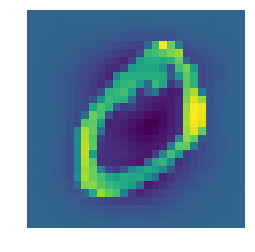

In [10]:
plt.imshow(X[0,:].reshape(28,28))
plt.axis('off');

In [11]:
y[0]

0

In [12]:
inputs_n = 28*28 #All observations are 28*28 pixels
hidden1_n = 300 #number of neurons in layer 1
hidden2_n = 100
outputs_n = 10 #Digits 0-9

In [13]:
tf.reset_default_graph()

In [14]:
X = tf.placeholder(tf.float32, shape=(None, inputs_n), name="X") #to feed mini batches
y = tf.placeholder(tf.int32, shape=(None), name="y")

Each neuron has an output that is the weighted sum of its inputs, with an activation applied. This implementations uses the rectified linear unit (ReLU) https://en.wikipedia.org/wiki/Rectifier_(neural_networks). The calculations for each layer can be vectorised like so:  

$Z = X \cdot W + b$  
Output = $Relu(Z)$

In [15]:
acti = tf.nn.relu

with tf.name_scope("neural_net"): #Architecture
    hidden1 = tf.layers.dense(X, hidden1_n, name="hidden1", activation=acti)
    hidden2 = tf.layers.dense(hidden1, hidden2_n, name="hidden2", activation=acti)
    logits = tf.layers.dense(hidden2, outputs_n, name="outputs")

In [16]:
with tf.name_scope("loss"): # Cost function
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(cross_entropy, name = "loss")

In [17]:
with tf.name_scope("train"): #Optimiser
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    training_op = optimiser.minimize(loss)

In [18]:
with tf.name_scope("eval"): # Evaluation metric (accuracy)
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
def fetch_batch(batch_index, batch_size):
    
    i1 = batch_index * batch_size
    i2 = i1 + batch_size
    
    batchX = X_train[i1:i2,:]
    batchY = y_train[i1:i2]
    
    return batchX, batchY

In [21]:
n_epochs = 100
batch_size = 40
n_batches = int(np.ceil(m / batch_size))

In [22]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(batch_index, batch_size)
            sess.run(training_op,feed_dict={X: X_batch, y: y_batch})

        if epoch % 10 == 0:    
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    save_path = saver.save(sess, "./savepoints/MNIST_mini_batch.ckpt")

0 Train accuracy: 1.0 Test accuracy: 0.156
10 Train accuracy: 1.0 Test accuracy: 0.2525
20 Train accuracy: 1.0 Test accuracy: 0.4123
30 Train accuracy: 1.0 Test accuracy: 0.4253
40 Train accuracy: 1.0 Test accuracy: 0.4903
50 Train accuracy: 1.0 Test accuracy: 0.6083
60 Train accuracy: 1.0 Test accuracy: 0.6587
70 Train accuracy: 1.0 Test accuracy: 0.6923
80 Train accuracy: 1.0 Test accuracy: 0.7158
90 Train accuracy: 1.0 Test accuracy: 0.7862


Further training required 